In [140]:
import caiman as cm
import labrotation.file_handling as fh
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import os.path
import json
from nd2_to_caiman import np_arr_from_nd2
import scipy
from RippleNoiseRemoval import RNR
from time import time
from movie_splitting import numpy_to_hdf5
from numba import njit, prange

In [2]:
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import params as params
from copy import deepcopy

In [3]:
# TODO in nb_view_components, the blue is raw trace, yellow is smooth (inferred?). Use blue trace for matching with manual extraction!

# Open h5 file

In [4]:
cnmf_path = fh.open_file("Open hdf5 caiman file")

In [9]:
cnmf = cm.source_extraction.cnmf.cnmf.load_CNMF(cnmf_path)

### Open corresponding json parameters file. Change code if naming changes!

In [10]:
pars_path, pars_fname = os.path.split(cnmf_path)
# xy_results.hdf5 -> xy_pars.json. Change this if the naming changes
pars_fname = "_".join(os.path.splitext(pars_fname)[0].split("_")[:-1]) + "_pars.json"
pars_path = os.path.join(pars_path, pars_fname)

In [11]:
with open(pars_path, "r") as json_file:
    js = json.load(json_file)

In [12]:
nd2_fpath = js["original_fnames"]

### (Optional) Open corresponding nd2 file

In [13]:
nik_data = np_arr_from_nd2(nd2_fpath)

C:\Users\Bence\anaconda3\envs\2p-py\lib\site-packages\pims\base_frames.py:472: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


KeyboardInterrupt: 

# Test by plotting detected cells

In [14]:
cnmf.estimates.plot_contours_nb()

In [67]:
cnmf.estimates.nb_view_components(denoised_color="red")

# Extract spatial coordinates in video

### scipy.sparse.csc_matrix (compressed sparse column matrix)
To produce a CSC formatted matrix from a numpy matrix (np.ndarray), go through the matrix column by column, and note the row indices (0 = topmost element of a column) of non-zero elements. Append these to an array, `indices`, and their data values to another array, `data`. Then, create a new array `indptr`. The element `i` and `i+1` should form an interval `[x, y)` such that `indices[x:y]` are the elements of the i-th column.
* `indices[indptr[i]:indptr[i+1]]` (note open interval on right! E.g. `[1:3] = {1, 2}`) contains the indices of the i-th column (i=0, ...) 
* `indptr` contains pointers to the column elements `indices`
* `data` contains the corresponding value for each `indices` entry.


In [ ]:
i_neuron = 467  # set a neuron by looking at cnmf.estimates.nb_view_components(). If the neuron there is i, write here i-1.
                # Find one where any mirroring can be easily detected

In [ ]:
type(cnmf.estimates.A[:,i_neuron])

In [ ]:
cnmf.estimates.A[:,i_neuron].indices.shape

In [ ]:
cnmf.estimates.A[:,i_neuron].indptr.shape

In [ ]:
cnmf.estimates.A[:,i_neuron].data.shape

In [ ]:
cnmf.estimates.A[:,i_neuron].indptr

In [ ]:
cnmf.estimates.A[:,i_neuron].data.min()

# Test re-indexing into 2d array shape

In [15]:
temporal = cnmf.estimates.C

In [16]:
spatial = cnmf.estimates.A.todense()

In [17]:
spatial.shape

(262144, 1166)

In [ ]:
neuron = spatial[:,i_neuron].reshape((512,512)).transpose()

### Check position of detected neuron. If mat is csc_matrix, then mat.nonzero() returns [x0, x1, ...], [y0, y1, ...] of (x, y) coordinates of nonzero elements. Need to check if these give back the original neuron

In [ ]:
fig = plt.figure(figsize=(18,18));
fig.suptitle("Reconstructed neuron; compare with nb_view_components() i+1 neuron", fontsize=20);
plt.imshow(neuron);


### Create binarized version of the frame

In [ ]:
neuron_binary = deepcopy(neuron)

In [ ]:
csc2 = scipy.sparse.csc_matrix(neuron)

In [ ]:
x, y = csc2.nonzero()  # returns two lists: [x0, x1, ...], [y0, y1, ...] of [xi, yi] coordinates of non-zero entries.

In [ ]:
xy = list(zip(x, y))

In [ ]:
for i_coord in range(len(x)):  # loop through 
    i_x = x[i_coord]
    i_y = y[i_coord]
    neuron_binary[i_x, i_y] = 1

In [ ]:
fig = plt.figure(figsize=(18,18));
fig.suptitle("Binarized neuron", fontsize=20);
plt.imshow(neuron_binary);

# Create weighted average of signal
The weights are the contents of the sparse matrix

## RNR and MoCo

In [ ]:
win = js["rnr_win"]
amplitude_threshold = js["amplitude_threshold"]

In [ ]:
# set export folder for temporary files
export_folder = fh.open_dir("Select folder to save results", True)
# export_fname: get rid of .nd2 extension, append date and .h5 extension
export_fname = fh.get_filename_with_date(os.path.splitext(os.path.split(nd2_fpath)[1])[0] + "_rnr_", ".hdf5")
export_hd5_fpath = os.path.join(export_folder, export_fname) # nd2_fpath.split("/")[-1][:-4] + "_exp.h5"
print(f"Export file selected: {export_hd5_fpath}")

In [ ]:
rnr = RNR(win, amplitude_threshold) 

In [ ]:
t0_open = time()
if "begin_end_frames" in locals():
    rnr.open_recording(nd2_fpath, begin_end_frames)  # opens usual recording size (8.8-9 GB) in about 830 s
else:
    rnr.open_recording(nd2_fpath)
print(f"File opened in {time() - t0_open} s")

In [ ]:
# TODO: make sure CNMF object contains MoCo shifts (in Pure Python Pipeline / Splitting), then use apply_shifts

In [ ]:
t0_single = time()
rnr_data = rnr.rnr_singlethread()  # a bit faster than opening file, around 500s for 8.8-9 GB
t1_single = time()
print(f"RNR single thread finished in {t1_single - t0_single} s")
print(f"Result is a {type(rnr_data)} with datatype {rnr_data.dtype}")
print(f"Shape: {rnr_data.shape[0]} frames of {rnr_data.shape[1]}x{rnr_data.shape[2]} pixels")

In [ ]:
numpy_to_hdf5(rnr_data, export_hd5_fpath)

In [ ]:
if "moco_intervals" in js.keys():
    moco_intervals = js["moco_intervals"]
    moco_flags = js["moco_flags"]
    cnmf_intervals = js["cnmf_intervals"]
    cnmf_flags = js["cnmf_flags"]
else:
    raise Exception("No segmentation info found.")

### Set output file

In [ ]:
if not("export_hd5_fpath" in locals()):
    export_hd5_fpath = fh.open_file("Choose hd5 file to open")
if export_hd5_fpath.split(".")[-1] != "hdf5":
    print(f"Invalid hd5 file:\n{export_hd5_fpath}\nChoose a valid hd5 file!")
    export_hd5_fpath = fh.open_file("Choose hd5 file to open")
fnames = [export_hd5_fpath]
print(f"Going to perform MoCo on {fnames}")
assert export_hd5_fpath.split(".")[-1] == "hdf5", f"Invalid file extension: .{export_hd5_fpath.split('.')[-1]}, expected .hdf5"

### Acquire parameters from json file

In [ ]:
for key in js.keys():
    print(key)

In [ ]:
js["strides"]

In [ ]:
# dataset dependent parameters
fr = js["fr"]                             # imaging rate in frames per second
decay_time = js["decay_time"]                  # length of a typical transient in seconds

# motion correction parameters
strides = tuple(js["strides"])          # start a new patch for pw-rigid motion correction every x pixels
overlaps = tuple(js["overlaps"])         # overlap between pathes (size of patch strides+overlaps)
max_shifts = tuple(js["max_shifts"])          # maximum allowed rigid shifts (in pixels)
max_deviation_rigid = js["max_deviation_rigid"]     # maximum shifts deviation allowed for patch with respect to rigid shifts
pw_rigid = js["pw_rigid"]             # flag for performing non-rigid motion correction

# parameters for source extraction and deconvolution
p = js["p"]                       # order of the autoregressive system
gnb = js["nb"]                     # number of global background components
merge_thr = js["merge_thr"]            # merging threshold, max correlation allowed
rf = js["rf"]                     # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = js["stride"]             # amount of overlap between the patches in pixels
K = js["K"]                       # number of components per patch
gSig = js["gSig"]               # expected half size of neurons in pixels
method_init = js["method_init"]  # initialization method (if analyzing dendritic data using 'sparse_nmf')
ssub = js["ssub"]                    # spatial subsampling during initialization
tsub = js["tsub"]                    # temporal subsampling during intialization

# parameters for component evaluation
min_SNR = js["min_SNR"]               # signal to noise ratio for accepting a component
rval_thr = js["rval_thr"]              # space correlation threshold for accepting a component
cnn_thr = js["min_cnn_thr"]              # threshold for CNN based classifier
cnn_lowest = js["cnn_lowest"] # neurons with cnn probability lower than this value are rejected

In [ ]:
if "fnames" not in locals():
    fnames = fh.open_file("No hd5 file selected. Choose corresponding hd5 file!")
opts_dict = {'fnames': fnames, 
            'fr': fr,
            'decay_time': decay_time,
            'strides': strides,
            'overlaps': overlaps,
            'max_shifts': max_shifts,
            'max_deviation_rigid': max_deviation_rigid,
            'pw_rigid': pw_rigid,
            'p': p,
            'nb': gnb,
            'rf': rf,
            'K': K, 
            'stride': stride_cnmf,
            'method_init': method_init,
            'rolling_sum': True,
            'only_init': True,
            'ssub': ssub,
            'tsub': tsub,
            'merge_thr': merge_thr, 
            'min_SNR': min_SNR,
            'rval_thr': rval_thr,
            'use_cnn': True,
            'min_cnn_thr': cnn_thr,
            'cnn_lowest': cnn_lowest,
            'var_name_hdf5': 'data',
            'gSig' :  gSig,}  # FIXME: does not work! Check where does this setting get lost?

opts = params.CNMFParams(params_dict=opts_dict)

## Set up cluster

In [ ]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

In [ ]:
mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))

### Perform MoCo on whole movie first, do not save the results yet

In [ ]:
mc.motion_correct(save_movie=False)

In [ ]:
x_shifts_els = deepcopy(mc.x_shifts_els)
y_shifts_els = deepcopy(mc.y_shifts_els)

In [ ]:
x_shape = x_shifts_els[0].shape
y_shape = y_shifts_els[0].shape
for i_piece, frames_tuple in enumerate(moco_intervals):
    if not moco_flags[i_piece]:  # skip this piece = set shifts to zero
         for i_frame in range(frames_tuple[0] -1 , frames_tuple[1]):  # include last frame as well
            x_shifts_els[i_frame] = np.zeros(x_shape)
            y_shifts_els[i_frame] = np.zeros(y_shape)

In [ ]:
mc.x_shifts_els = x_shifts_els
mc.y_shifts_els = y_shifts_els

In [ ]:
work_folder = os.path.split(fnames[0])[0]
print(f"Changing work folder to {work_folder}, this is where moco result will be saved")

In [ ]:
os.chdir(work_folder)

In [ ]:
# should save in C order because cm.load_memmap() takes C-memmap. However, as the opening and closing of memmap files is 
# so confusing, I decided to try to copy the original demo_pipeline jupyter notebook as closely as I can.
exp_fname = mc.apply_shifts_movie(fnames, save_memmap=True,order="F")
print(exp_fname)

### At this point, we have the shifts for specific intervals in the recording, even if they were not saved before. We need to apply them to the whole recording.

In [ ]:
# TODO: if shifts in CNMF object, need to open file in MoCo, apply shifts, save to memmap and open memmap

In [ ]:
mc_mmap = os.path.join(work_folder, exp_fname)

In [ ]:
#exp_fname2 = mc.apply_shifts_movie(fnames, save_memmap=True,order="C")
#mc_mmap2 = os.path.join(work_folder, exp_fname2)

In [ ]:
m_els = cm.load(mc_mmap)
border_to_0 = 0 if mc.border_nan is 'copy' else mc.border_to_0  # FIXME: gives warning, should use "==" with literals
    # maximum shift to be used for trimming against NaNs

In [5]:
if "mc_mmap" not in locals():
    mc_mmap = fh.open_file("Choose motion-corrected recording mmap!")

In [6]:
#m_els_C = cm.load(mc_mmap2)
m_els = cm.load(mc_mmap)

In [7]:
m_els.shape

(17978, 512, 512)

In [18]:
spatial.shape  # no. pixels (512x512) x no. neurons

(262144, 1166)

In [19]:
temporal.shape  # no. neurons x no. frames

(1166, 15737)

In [20]:
n_neurons = temporal.shape[0]
n_frames_cut = temporal.shape[1]
n_frames_long = m_els.shape[0]

In [ ]:
# check intervals are consistent with temporal size
n_frs = 0
for i_tup, tup in enumerate(js["cnmf_intervals"]):
    if js["cnmf_flags"][i_tup]:
        n_frs += tup[1] - tup[0] + 1
print(n_frs)
print(n_frs == n_frames_cut)

In [ ]:
traces_cut = np.zeros((n_neurons, n_frames_cut), dtype=m_els.dtype)  # same shape as temporal
traces_whole = np.zeros((n_neurons, n_frames_long), dtype=m_els.dtype)

In [ ]:
neuron_signal_cut = np.zeros((n_neurons, n_frames_cut), dtype=m_els.dtype)  # same shape as temporal
neuron_signal_whole = np.zeros((n_neurons, n_frames_long), dtype=m_els.dtype)

In [ ]:
neuron_weight = np.zeros(n_neurons, dtype=m_els.dtype)
for i_neuron in range(n_neurons):
    weight = 0
    neuron_mask = spatial[:,i_neuron].reshape((512,512)).transpose()  # do not confuse with elon musk
    pixels_x, pixels_y = scipy.sparse.csc_matrix(neuron_mask).nonzero()
    for pix_x, pix_y in zip(pixels_x, pixels_y):
        weight += neuron_mask[pix_x, pix_y]
    neuron_weight[i_neuron] = weight

In [ ]:
neuron_weight

In [ ]:
# frame-first method

# extract whole trace per frame:
# calculate for each neuron sum(pixels of neuron) {pixel weight}*{pixel temporal value}
for i_frame in range(m_els.shape[0]):
    print(i_frame)
    for i_neuron in range(n_neurons):
        neuron_mask = spatial[:,i_neuron].reshape((512,512)).transpose()  # do not confuse with elon musk
        pixels_x, pixels_y = scipy.sparse.csc_matrix(neuron_mask).nonzero()
        neuron_signal = 0  # the nominator
        total_weight = 0  # the denominator
        for pix_x, pix_y in zip(pixels_x, pixels_y):
            neuron_signal += neuron_mask[pix_x, pix_y]*m_els[i_frame, pix_x, pix_y]  # add weight x trace of pixel to total
        traces_whole[i_neuron, i_frame] = neuron_signal / neuron_weight[i_neuron]
        neuron_signal_whole[i_neuron, i_frame] = neuron_signal

In [ ]:
# based on this simple test, TXY order with F order in apply_shifts is the fastest way. I.e. the loop 
# over frames is the slowest-changing, Y the quickest.

test_C_vs_F = False
if test_C_vs_F:
    # test reading various pixels throughout whole range
    print("T-major approach")
    t0 = time()
    s = 0
    for i_x in range(30):
        for i_y in range(30):
            for i_frame in range(m_els.shape[0]):
                s += m_els[i_frame, 10+i_x, 200+i_y]
            s = 0
    t1 = time()
    print(f"F order: {t1-t0}")

    t0C = time()
    s = 0
    for i_x in range(30):
        for i_y in range(30):
            for i_frame in range(m_els_C.shape[0]):
                s += m_els_C[i_frame, 10+i_x, 200+i_y]
            s = 0
    t1C = time()

    print(f"C order: {t1C-t0C}")
    
    print("XY-major approach")
    t0 = time()
    s = 0
    print("TXY")
    for i_frame in range(m_els.shape[0]):
        for i_x in range(30):
            for i_y in range(30):
                s += m_els[i_frame, 10+i_x, 200+i_y]
        s = 0
    t1 = time()
    print(f"F order: {t1-t0}")

    t0C = time()
    s = 0
    for i_frame in range(m_els_C.shape[0]):
        for i_x in range(30):
            for i_y in range(30):
                s += m_els_C[i_frame, 10+i_x, 200+i_y]
        s = 0
    t1C = time()
    print(f"C order: {t1C-t0C}")
    print("TYX")
    t0 = time()
    s = 0
    for i_frame in range(m_els.shape[0]):
        for i_y in range(30):
            for i_x in range(30):
                s += m_els[i_frame, 10+i_x, 200+i_y]
        s = 0
    t1 = time()
    print(f"F order: {t1-t0}")

    t0C = time()
    s = 0
    for i_frame in range(m_els_C.shape[0]):
        for i_y in range(30):
            for i_x in range(30):
                s += m_els_C[i_frame, 10+i_x, 200+i_y]
        s = 0
    t1C = time()
    print(f"C order: {t1C-t0C}")

In [ ]:
# pixel-first method

# extract whole trace per frame:
# calculate for each neuron sum(pixels of neuron) {pixel weight}*{pixel temporal value}
for i_neuron in range(n_neurons):
    print(i_neuron)
    neuron_mask = spatial[:,i_neuron].reshape((512,512)).transpose()  # do not confuse with elon musk
    pixels_x, pixels_y = scipy.sparse.csc_matrix(neuron_mask).nonzero()
    for pix_x, pix_y in zip(pixels_x, pixels_y):
        for i_frame in range(m_els.shape[0]):
            pixel_signal = neuron_mask[pix_x, pix_y]*m_els[i_frame, pix_x, pix_y]
            traces_whole[i_neuron, i_frame] += pixel_signal / neuron_weight[i_neuron]
            neuron_signal_whole[i_neuron, i_frame] += pixel_signal

# Attempt at parallelizing the trace extraction algorithm

In [23]:
moco_data = np.asarray(m_els.data)

In [26]:
moco_data.shape

(17978, 512, 512)

In [45]:
spatial.shape

(262144, 1166)

In [53]:
spatial = np.array(spatial)

In [57]:
spatial = np.reshape(spatial, (512, 512, 1166))

In [91]:
spatial.shape

(512, 512, 1166)

In [92]:
spatial = np.transpose(spatial, axes=[1,0,2])

In [93]:
spatial.shape

(512, 512, 1166)

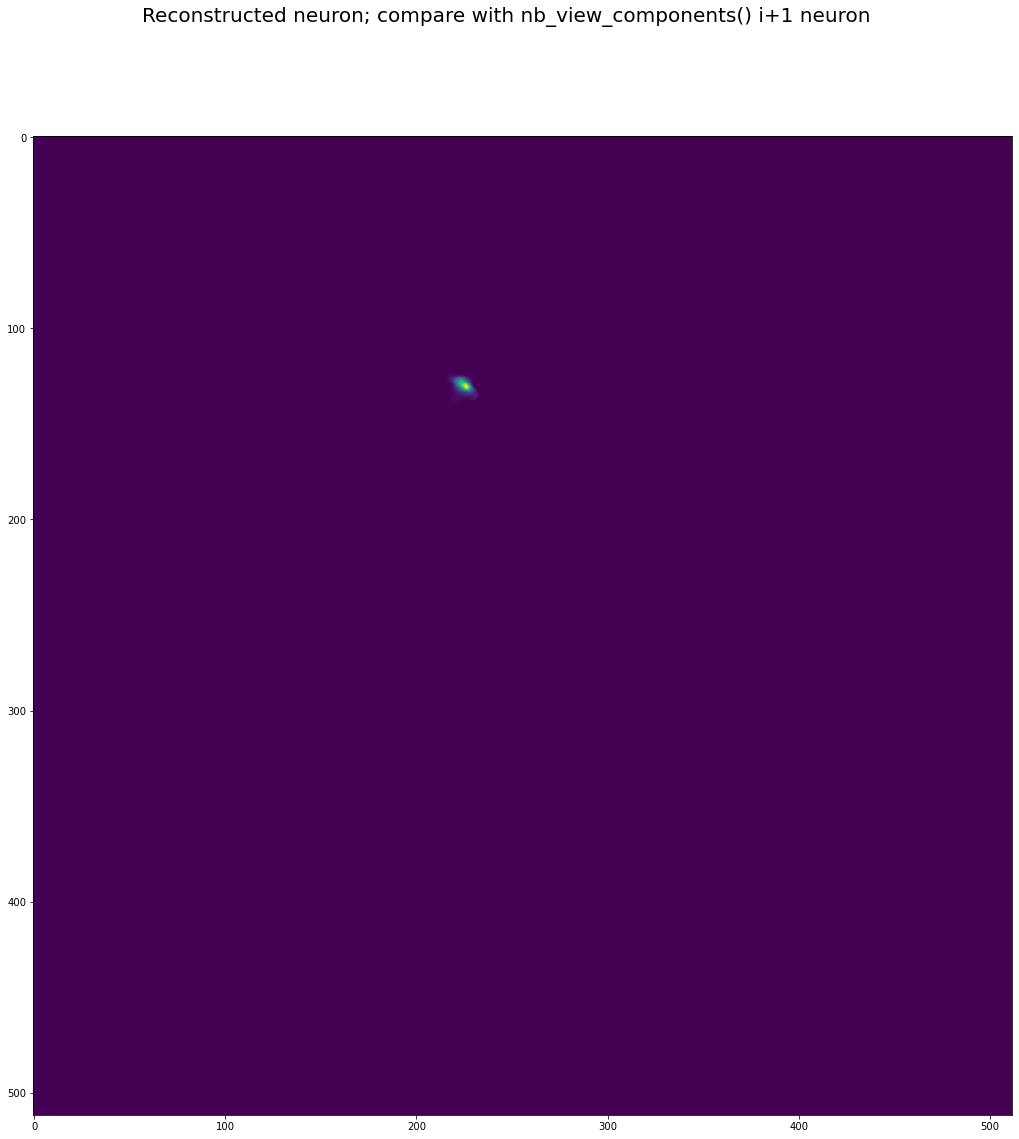

In [96]:
fig = plt.figure(figsize=(18,18));
fig.suptitle("Reconstructed neuron; compare with nb_view_components() i+1 neuron", fontsize=20);
plt.imshow(spatial[:,:,222]);

In [31]:
i_neu = 222

In [97]:
neu_mask = spatial[:,:,i_neu]
pix_x, pix_y = scipy.sparse.csc_matrix(neu_mask).nonzero()

In [98]:
moco_data[:, pix_x, pix_y].shape

(17978, 185)

In [46]:
spatial[:,0].reshape((512,512))

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
spatial[pix_x, pix_y, i_neu]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
n_frames_long

In [122]:
b = np.array([[0, 1], [2, 3], [4, 5], [6, 7]])

In [124]:
c = np.array([10, 100])

In [126]:
b

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [127]:
c

array([ 10, 100])

In [128]:
b.shape

(4, 2)

In [129]:
c.shape

(2,)

In [125]:
b*c

array([[  0, 100],
       [ 20, 300],
       [ 40, 500],
       [ 60, 700]])

In [132]:
np.sum(b*c, axis=1)

array([100, 320, 540, 760])

In [117]:
spatial[pix_x, pix_y, i_neu].shape

(185,)

In [116]:
(moco_data[:, pix_x, pix_y]*spatial[pix_x, pix_y, i_neu]).shape

(17978, 185)

In [105]:
px.shape

(185,)

In [158]:
pix_x, pix_y = spatial[:,:,222].nonzero()
np.sum(moco_data[:, pix_x, pix_y]*spatial[pix_x, pix_y, 222], axis=1).shape

(17978,)

In [ ]:
for i_pix in range(len(pix_x)):
    x = pix_x[]

In [179]:
weights_par = np.sum(spatial, axis=(0,1))
traces_par = np.zeros((n_neurons, n_frames_long), dtype=moco_data.dtype)

# The algorithm below seems to work well, and fast! (JIT + parallelization)

In [184]:
@njit(parallel=True)
def extract_neuron_trace():  # neuron_xy = np.array[x0, x1, ..., xn; y0, y1, ..., yn], 2 rows, n columns
    traces_par = np.zeros((n_neurons, n_frames_long), dtype=moco_data.dtype)    
    for i_neuron in prange(n_neurons):
        pixels_x, pixels_y = spatial[:,:,i_neuron].nonzero()
        trace = np.zeros((n_frames_long,), dtype=moco_data.dtype)
        for i_frame in range(n_frames_long):
            trace_val = 0.
            i_pix = 0
            while i_pix < pixels_x.shape[0]:
                trace_val = trace_val + spatial[pixels_x[i_pix], pixels_y[i_pix], i_neuron]*moco_data[i_frame, pixels_x[i_pix], pixels_y[i_pix]]
                i_pix = i_pix + 1
            traces_par[i_neuron, i_frame] = trace_val
        #np.sum(moco_data[:, pixels_x, pixels_y]*spatial[pixels_x, pixels_y, i_neuron], axis=1)
    return traces_par

In [195]:
tr = extract_neuron_trace()


In [190]:
tr_norm = np.divide(tr, weights_par[:, None])

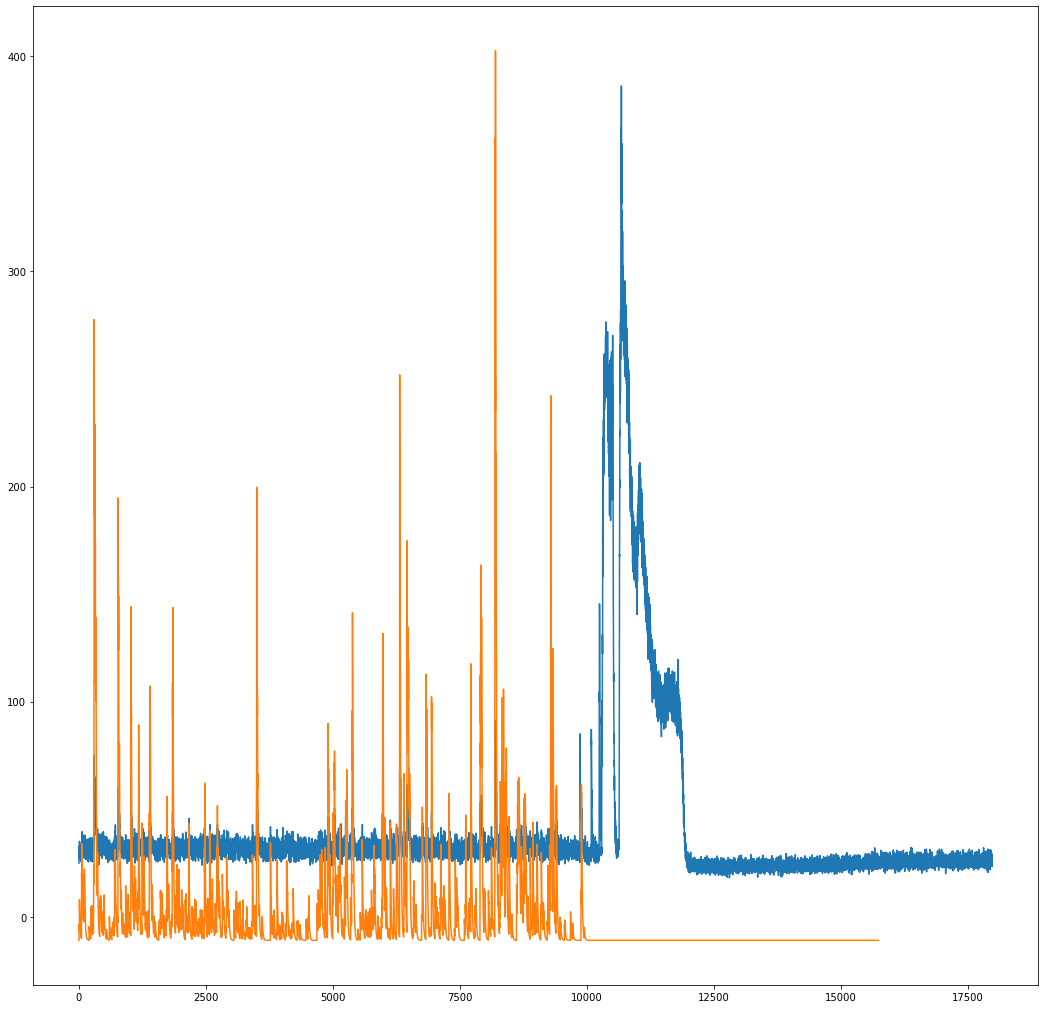

In [194]:
i_n = 222
fig = plt.figure(figsize=(18,18))
#plt.plot(tr[i_n, :])
plt.plot(tr_norm[i_n,:])
plt.plot(temporal[i_n])
plt.show()

## Desperate attempt: try not to save moco, but try to access the data in the RAM somehow.

In [ ]:
fnames

In [ ]:
moco_imp = mc.apply_shifts_movie(fnames, save_memmap=False)

In [ ]:
moco_data = np.asarray(moco_imp.data)

In [ ]:
moco_data.shape

In [ ]:
neuron_signal_cut = np.zeros((n_neurons, n_frames_cut), dtype=m_els.dtype)  # same shape as temporal
neuron_signal_whole = np.zeros((n_neurons, n_frames_long), dtype=m_els.dtype)

In [ ]:
# calculate for each neuron sum(pixels of neuron) {pixel weight}*{pixel temporal value}
for i_neuron in range(n_neurons):
    print(i_neuron)
    neuron_mask = spatial[:,i_neuron].reshape((512,512)).transpose()  # do not confuse with elon musk
    pixels_x, pixels_y = scipy.sparse.csc_matrix(neuron_mask).nonzero()
    neuron_signal = 0  # the nominator
    total_weight = 0  # the denominator
    for pix_x, pix_y in zip(pixels_x, pixels_y):
        for i_frame in range(moco_data.shape[0]):
            neuron_signal_whole[i_neuron, i_frame] += neuron_mask[pix_x, pix_y]*moco_data[i_frame, pix_x, pix_y]

In [ ]:
# frame-first method

# extract whole trace per frame:
# calculate for each neuron sum(pixels of neuron) {pixel weight}*{pixel temporal value}
for i_frame in range(moco_data.shape[0]):
    print(i_frame)
    for i_neuron in range(n_neurons):
        neuron_mask = spatial[:,i_neuron].reshape((512,512)).transpose()  # do not confuse with elon musk
        pixels_x, pixels_y = scipy.sparse.csc_matrix(neuron_mask).nonzero()
        neuron_signal = 0  # the nominator
        total_weight = 0  # the denominator
        for pix_x, pix_y in zip(pixels_x, pixels_y):
            neuron_signal += neuron_mask[pix_x, pix_y]*m_els[i_frame, pix_x, pix_y]  # add weight x trace of pixel to total
        #traces_whole[i_neuron, i_frame] = neuron_signal / neuron_weight[i_neuron]
        neuron_signal_whole[i_neuron, i_frame] = neuron_signal

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
fig = plt.figure(figsize=(18,18))
plt.plot(neuron_signal_whole[440,:], label="manual extraction")
plt.plot(temporal[440,:], label="cnmf")
plt.xlim((7500,12000))
plt.legend(fontsize=20)
plt.show()

# Show CNMF results

In [ ]:
#fig = plt.figure(figsize=(18,18))

#plt.show()

In [ ]:
# need C and 
cnmf.estimates.C

In [ ]:
covmat = np.cov(cnmf.estimates.C)
corrmat = np.corrcoef(cnmf.estimates.C)

In [ ]:
covmat

In [ ]:
fig = plt.figure(figsize=(18,18))
plt.imshow(corrmat, interpolation="none")
plt.show()

In [ ]:
fig = plt.figure(figsize=(18,18))
plt.imshow(corrmat[:50, :50], interpolation="none")
plt.show()

# Visualise connections as graph
https://stackoverflow.com/questions/60392714/nodes-clusters-on-weighted-graph-visualization
https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx/43541777#43541777

In [ ]:
from pyvis.network import Network

In [ ]:
n_neurons = 50

In [ ]:
net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white')
net.force_atlas_2based()
for i in range(n_neurons):
    net.add_node(i)
for i in range(n_neurons):
    for j in range(i+1, n_neurons):
        net.add_edge(i, j, weight=(covmat[i,j] + 1)/2)

#net.toggle_physics(True)
net.show("vis.html")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# installation easiest via pip:
# pip install netgraph
from netgraph import Graph

# create a modular graph
partition_sizes = [10, 20, 30, 40]
g = nx.random_partition_graph(partition_sizes, 0.5, 0.1)

# since we created the graph, we know the best partition:
node_to_community = dict()
node = 0
for community_id, size in enumerate(partition_sizes):
    for _ in range(size):
        node_to_community[node] = community_id
        node += 1

# # alternatively, we can infer the best partition using Louvain:
# from community import community_louvain
# node_to_community = community_louvain.best_partition(g)

community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
}
node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

Graph(g,
      node_color=node_color, node_edge_width=0, edge_alpha=0.1,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
)

plt.show()

In [ ]:
# TODO: use igraph to plot graph? https://igraph.org/python/tutorial/latest/tutorial.html#layout-algorithms

In [ ]:
# TODO: get physical distance of neurons, too? Then we can plot distance-correlation as scatter plot.

In [ ]:
 #TODO: useful links:
    # https://stackoverflow.com/questions/3081066/what-techniques-exists-in-r-to-visualize-a-distance-matrix
    # https://igraph.org/python/doc/tutorial/tutorial.html
    # https://stats.stackexchange.com/questions/165194/using-correlation-as-distance-metric-for-hierarchical-clustering

In [ ]:
mat = np.array([[0, 0, 0, 1, 0, 0], [0, 2, 0, 0, 3, 0], [0, 4, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 6, 7, 0]])

In [ ]:
mat

In [ ]:
mat_sparse = scipy.sparse.csc_matrix(mat)

In [ ]:
mat_sparse.indices

In [ ]:
mat_sparse.indptr

In [ ]:
mat_sparse.data

In [ ]:
cnmf.estimates.shifts

In [ ]:
import h5py

In [ ]:
neuron_weight.shape

In [ ]:
with h5py.File("D:\\Interpolation_test\\Load_CNMF\\extracted_temporal.h5py", 'w') as hf:
    hf.create_dataset("neuron_signal_whole", data=neuron_signal_whole)
    hf.create_dataset("neuron_weight", data=neuron_weight)
    hf.create_dataset("x_shifts_els", data=x_shifts_els)
    hf.create_dataset("y_shifts_els", data=y_shifts_els)

In [ ]:
print("hi")